# Financial Sentiment Analysis with FinBERT
Fine-tuning ProsusAI/finbert on Financial PhraseBank dataset with weighted cross-entropy loss, cross-validation, and full evaluation.

## 1. Install and Import Libraries

In [1]:
!pip install transformers datasets scikit-learn torch torchvision -q

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## 2. Load Dataset
Dataset: Financial PhraseBank from Kaggle


In [4]:
DATA_PATH = '/kaggle/input/datasets/ankurzing/sentiment-analysis-for-financial-news/all-data.csv'

df = pd.read_csv(DATA_PATH, encoding='latin-1', header=None, names=['label', 'text'])
df = df.dropna().drop_duplicates(subset='text').reset_index(drop=True)

print(f'Total samples: {len(df)}')
print(df['label'].value_counts())
df.head()

Total samples: 4838
label
neutral     2872
positive    1362
negative     604
Name: count, dtype: int64


,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## 3. Exploratory Data Analysis

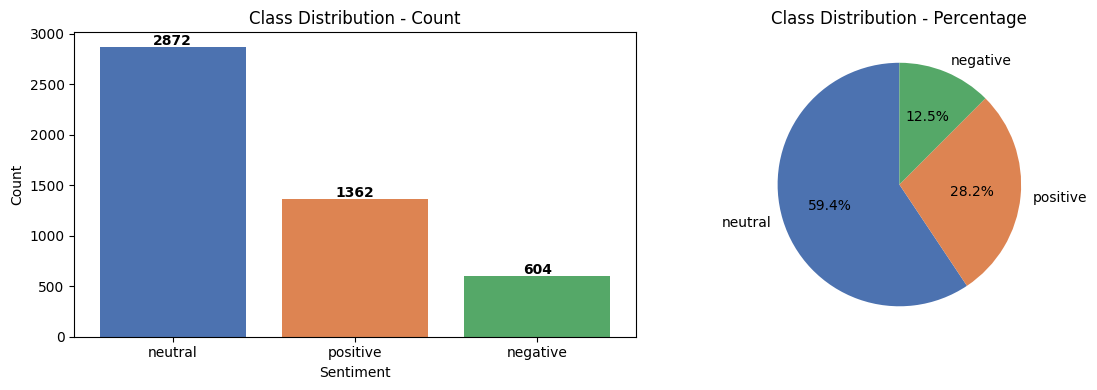

Class percentages:
  neutral: 59.4%
  positive: 28.2%
  negative: 12.5%


In [5]:
label_counts = df['label'].value_counts()
label_pcts = df['label'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(label_counts.index, label_counts.values, color=['#4C72B0', '#DD8452', '#55A868'])
axes[0].set_title('Class Distribution - Count')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for i, (cls, cnt) in enumerate(label_counts.items()):
    axes[0].text(i, cnt + 20, str(cnt), ha='center', fontweight='bold')

axes[1].pie(label_pcts.values, labels=label_pcts.index, autopct='%1.1f%%',
            colors=['#4C72B0', '#DD8452', '#55A868'], startangle=90)
axes[1].set_title('Class Distribution - Percentage')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('Class percentages:')
for cls, pct in label_pcts.items():
    print(f'  {cls}: {pct:.1f}%')

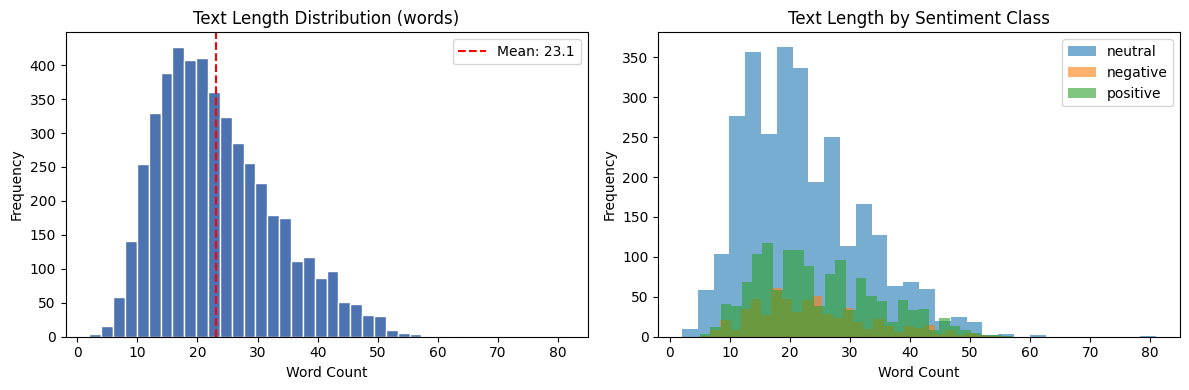

Mean text length: 23.1 words
Max text length: 81 words
95th percentile: 42 words


In [6]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['text_length'], bins=40, color='#4C72B0', edgecolor='white')
axes[0].set_title('Text Length Distribution (words)')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["text_length"].mean():.1f}')
axes[0].legend()

for lbl in df['label'].unique():
    axes[1].hist(df[df['label'] == lbl]['text_length'], bins=30, alpha=0.6, label=lbl)
axes[1].set_title('Text Length by Sentiment Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Mean text length: {df["text_length"].mean():.1f} words')
print(f'Max text length: {df["text_length"].max()} words')
print(f'95th percentile: {df["text_length"].quantile(0.95):.0f} words')

## 4. Data Preprocessing

In [7]:
import re

LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

def clean_text(text):
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text)
    return text

df['text'] = df['text'].apply(clean_text)
df['label_id'] = df['label'].map(LABEL2ID)
df = df.dropna(subset=['label_id']).reset_index(drop=True)
df['label_id'] = df['label_id'].astype(int)

print(f'Final dataset size: {len(df)}')
print(df[['label', 'label_id']].value_counts().sort_index())

Final dataset size: 4838
label     label_id
negative  0            604
neutral   1           2872
positive  2           1362
Name: count, dtype: int64


In [8]:
MODEL_NAME = 'ProsusAI/finbert'
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 4
LR = 2e-5
WARMUP_RATIO = 0.1
N_FOLDS = 5
OUTPUT_DIR = '/kaggle/working/finbert_finetuned'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print('Tokenizer loaded')

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded


## 5. PyTorch Dataset Class

In [9]:
class SentimentDataset(Dataset):
    """
    PyTorch Dataset for financial sentiment classification.
    Tokenizes text using BERT tokenizer and returns input tensors.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## 6. Weighted Cross-Entropy Loss
Class imbalance: ~60% neutral, ~25% positive, ~15% negative.
Weights are computed using inverse class frequency to penalize majority class predictions.

In [10]:
def compute_class_weights(labels, n_classes=3):
    """
    Compute inverse frequency class weights.
    Higher weight assigned to minority classes (negative sentiment).
    Based on: weight_i = total_samples / (n_classes * count_i)
    """
    counts = np.bincount(labels, minlength=n_classes)
    total = len(labels)
    weights = total / (n_classes * counts)
    weights = weights / weights.sum() * n_classes
    return torch.tensor(weights, dtype=torch.float)

class_weights = compute_class_weights(df['label_id'].values)
print('Class weights (negative, neutral, positive):')
for i, (cls, w) in enumerate(zip(ID2LABEL.values(), class_weights)):
    count = (df['label_id'] == i).sum()
    pct = count / len(df) * 100
    print(f'  {cls}: weight={w:.4f}, count={count}, pct={pct:.1f}%')

Class weights (negative, neutral, positive):
  negative: weight=1.8140, count=604, pct=12.5%
  neutral: weight=0.3815, count=2872, pct=59.4%
  positive: weight=0.8045, count=1362, pct=28.2%


## 7. Training and Evaluation Functions

In [11]:
def train_epoch(model, loader, optimizer, scheduler, criterion, device):
    """Single training epoch. Returns average loss and accuracy."""
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        loss = criterion(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def eval_epoch(model, loader, criterion, device):
    """Evaluation pass. Returns loss, accuracy, all predictions and true labels."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / total, all_preds, all_labels

## 8. Cross-Validation Training

In [12]:
texts = df['text'].tolist()
labels = df['label_id'].tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f'Fold {fold + 1}/{N_FOLDS}')

    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    train_ds = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds = SentimentDataset(val_texts, val_labels, tokenizer, MAX_LEN)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=ID2LABEL,
        label2id=LABEL2ID
    ).to(DEVICE)

    cw = compute_class_weights(train_labels).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    total_steps = len(train_loader) * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    fold_train_losses, fold_val_losses = [], []

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, DEVICE)
        val_loss, val_acc, val_preds, val_true = eval_epoch(model, val_loader, criterion, DEVICE)
        fold_train_losses.append(tr_loss)
        fold_val_losses.append(val_loss)
        f1 = f1_score(val_true, val_preds, average='weighted')
        print(f'  Epoch {epoch+1}: train_loss={tr_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_f1={f1:.4f}')

    cv_results.append({
        'fold': fold + 1,
        'val_acc': val_acc,
        'val_f1': f1,
        'train_losses': fold_train_losses,
        'val_losses': fold_val_losses
    })

    del model
    torch.cuda.empty_cache()

print('\nCross-Validation Results:')
accs = [r['val_acc'] for r in cv_results]
f1s = [r['val_f1'] for r in cv_results]
print(f'Mean Accuracy: {np.mean(accs):.4f} +/- {np.std(accs):.4f}')
print(f'Mean F1:       {np.mean(f1s):.4f} +/- {np.std(f1s):.4f}')

Fold 1/5


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  Epoch 1: train_loss=1.2219, val_loss=0.4026, val_acc=0.8471, val_f1=0.8498
  Epoch 2: train_loss=0.2889, val_loss=0.3067, val_acc=0.8740, val_f1=0.8757
  Epoch 3: train_loss=0.1616, val_loss=0.3335, val_acc=0.8812, val_f1=0.8823
  Epoch 4: train_loss=0.0944, val_loss=0.3509, val_acc=0.8771, val_f1=0.8786
Fold 2/5


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Epoch 1: train_loss=1.2307, val_loss=0.4181, val_acc=0.8430, val_f1=0.8454
  Epoch 2: train_loss=0.2799, val_loss=0.3135, val_acc=0.8740, val_f1=0.8756
  Epoch 3: train_loss=0.1473, val_loss=0.3343, val_acc=0.8812, val_f1=0.8822
  Epoch 4: train_loss=0.0915, val_loss=0.3654, val_acc=0.8750, val_f1=0.8764
Fold 3/5


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Epoch 1: train_loss=1.1847, val_loss=0.4123, val_acc=0.8399, val_f1=0.8432
  Epoch 2: train_loss=0.2853, val_loss=0.3171, val_acc=0.8926, val_f1=0.8929
  Epoch 3: train_loss=0.1527, val_loss=0.3571, val_acc=0.8936, val_f1=0.8938
  Epoch 4: train_loss=0.0888, val_loss=0.3765, val_acc=0.8988, val_f1=0.8985
Fold 4/5


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Epoch 1: train_loss=1.2348, val_loss=0.3747, val_acc=0.8687, val_f1=0.8701
  Epoch 2: train_loss=0.3016, val_loss=0.3110, val_acc=0.8780, val_f1=0.8795
  Epoch 3: train_loss=0.1695, val_loss=0.3212, val_acc=0.8800, val_f1=0.8811
  Epoch 4: train_loss=0.0975, val_loss=0.3423, val_acc=0.8800, val_f1=0.8810
Fold 5/5


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Epoch 1: train_loss=1.2071, val_loss=0.3987, val_acc=0.8552, val_f1=0.8573
  Epoch 2: train_loss=0.2998, val_loss=0.3231, val_acc=0.8687, val_f1=0.8703
  Epoch 3: train_loss=0.1673, val_loss=0.3207, val_acc=0.8759, val_f1=0.8773
  Epoch 4: train_loss=0.0999, val_loss=0.3236, val_acc=0.8842, val_f1=0.8850

Cross-Validation Results:
Mean Accuracy: 0.8830 +/- 0.0085
Mean F1:       0.8839 +/- 0.0079


## 9. Final Model Training on Full Train Set

In [15]:
from tqdm import tqdm

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=SEED, stratify=labels
)
print(f'Train: {len(train_texts)}, Test: {len(test_texts)}')

train_ds = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_ds = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

final_model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=ID2LABEL,
    label2id=LABEL2ID
).to(DEVICE)

cw = compute_class_weights(train_labels).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=cw)
optimizer = AdamW(final_model.parameters(), lr=LR, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

train_losses, val_losses = [], []

epoch_pbar = tqdm(range(EPOCHS), desc='Final Model Training')
for epoch in epoch_pbar:
    tr_loss, tr_acc = train_epoch(
        final_model, train_loader, optimizer, scheduler, criterion, DEVICE
    )
    val_loss, val_acc, _, _ = eval_epoch(
        final_model, test_loader, criterion, DEVICE
    )
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    epoch_pbar.set_postfix({
        'tr_loss' : f'{tr_loss:.4f}',
        'val_loss': f'{val_loss:.4f}',
        'val_acc' : f'{val_acc:.4f}'
    })
    print(f'Epoch {epoch+1}: train_loss={tr_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')

Train: 4112, Test: 726


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Final Model Training:  25%|██▌       | 1/4 [00:53<02:39, 53.09s/it, tr_loss=1.2125, val_loss=0.3968, val_acc=0.8471]

Epoch 1: train_loss=1.2125, val_loss=0.3968, val_acc=0.8471


Final Model Training:  50%|█████     | 2/4 [01:44<01:44, 52.33s/it, tr_loss=0.2876, val_loss=0.2917, val_acc=0.8774]

Epoch 2: train_loss=0.2876, val_loss=0.2917, val_acc=0.8774


Final Model Training:  75%|███████▌  | 3/4 [02:36<00:52, 52.13s/it, tr_loss=0.1548, val_loss=0.3157, val_acc=0.8788]

Epoch 3: train_loss=0.1548, val_loss=0.3157, val_acc=0.8788


Final Model Training: 100%|██████████| 4/4 [03:28<00:00, 52.24s/it, tr_loss=0.0906, val_loss=0.3261, val_acc=0.8857]

Epoch 4: train_loss=0.0906, val_loss=0.3261, val_acc=0.8857


## 10. Evaluation and Visualizations

In [16]:
_, test_acc, test_preds, test_true = eval_epoch(final_model, test_loader, criterion, DEVICE)

print('Final Test Results')
print(f'Accuracy: {test_acc:.4f}')
print(f'Weighted F1: {f1_score(test_true, test_preds, average="weighted"):.4f}')
print()
print(classification_report(test_true, test_preds, target_names=['negative', 'neutral', 'positive']))

Final Test Results
Accuracy: 0.8857
Weighted F1: 0.8865

              precision    recall  f1-score   support

    negative       0.86      0.96      0.91        91
     neutral       0.94      0.88      0.91       431
    positive       0.81      0.87      0.84       204

    accuracy                           0.89       726
   macro avg       0.87      0.90      0.88       726
weighted avg       0.89      0.89      0.89       726



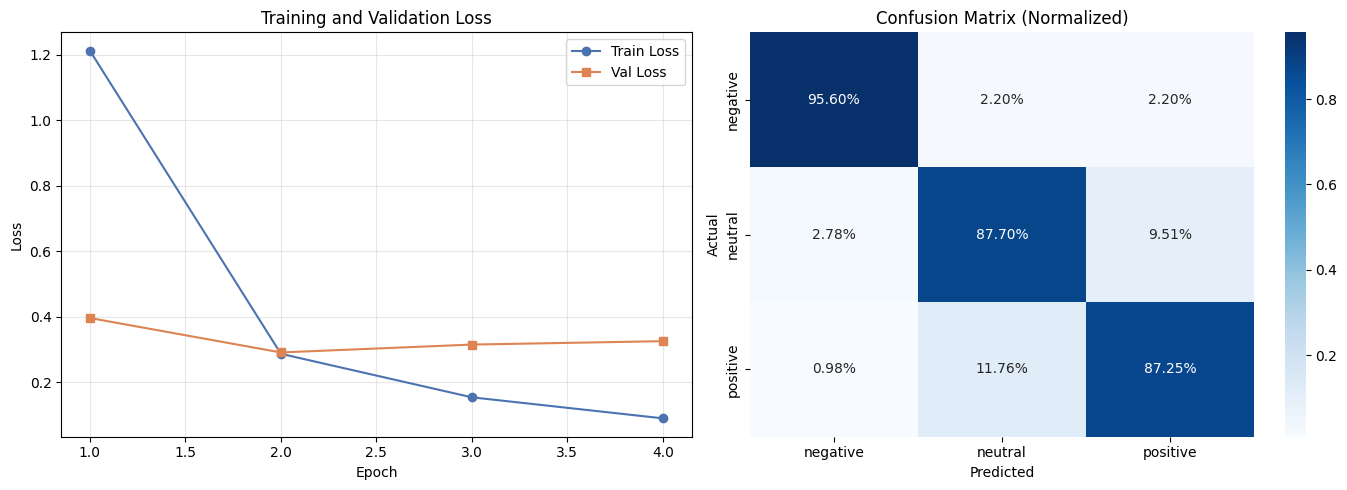

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss', color='#4C72B0')
axes[0].plot(range(1, EPOCHS+1), val_losses, marker='s', label='Val Loss', color='#DD8452')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

cm = confusion_matrix(test_true, test_preds)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(
    cm_pct, annot=True, fmt='.2%', cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive'],
    ax=axes[1]
)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

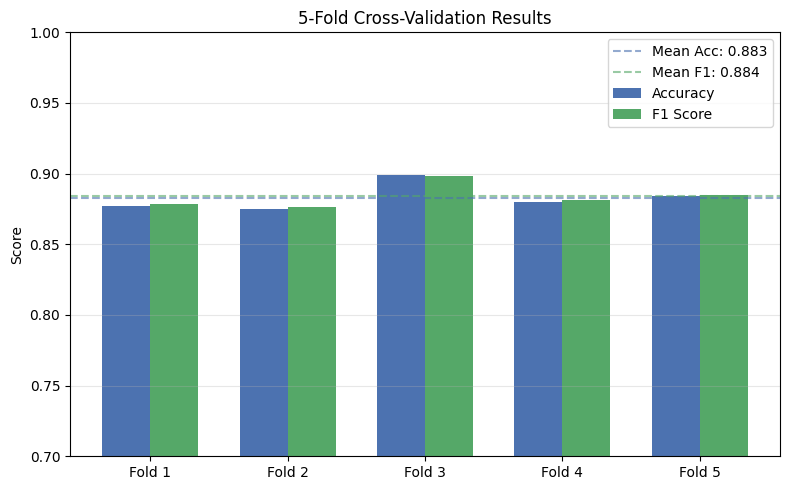

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

folds = [r['fold'] for r in cv_results]
fold_accs = [r['val_acc'] for r in cv_results]
fold_f1s = [r['val_f1'] for r in cv_results]

x = np.arange(len(folds))
w = 0.35
ax.bar(x - w/2, fold_accs, w, label='Accuracy', color='#4C72B0')
ax.bar(x + w/2, fold_f1s, w, label='F1 Score', color='#55A868')
ax.axhline(np.mean(fold_accs), color='#4C72B0', linestyle='--', alpha=0.6, label=f'Mean Acc: {np.mean(fold_accs):.3f}')
ax.axhline(np.mean(fold_f1s), color='#55A868', linestyle='--', alpha=0.6, label=f'Mean F1: {np.mean(fold_f1s):.3f}')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {f}' for f in folds])
ax.set_title('5-Fold Cross-Validation Results')
ax.set_ylabel('Score')
ax.set_ylim(0.7, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cross_validation_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Save Model and Tokenizer

In [19]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
final_model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f'Model saved to {OUTPUT_DIR}')
print('Files saved:')
for f in os.listdir(OUTPUT_DIR):
    print(f'  {f}')

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to /kaggle/working/finbert_finetuned
Files saved:
  tokenizer_config.json
  model.safetensors
  config.json
  tokenizer.json


In [24]:
import shutil

shutil.make_archive('/kaggle/working/finbert_finetuned', 'zip', '/kaggle/working/finbert_finetuned')
print('Done! Download finbert_finetuned.zip from the output panel')

<IPython.core.display.Javascript object>

## 12. Quick Inference Test

In [20]:
def predict_sentiment(text, model, tokenizer, device, max_len=64):
    """Run inference on a single financial text string."""
    model.eval()
    enc = tokenizer(
        text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    with torch.no_grad():
        out = final_model(
            input_ids=enc['input_ids'].to(device),
            attention_mask=enc['attention_mask'].to(device),
            token_type_ids=enc['token_type_ids'].to(device)
        )
    probs = torch.softmax(out.logits, dim=1).squeeze().cpu().numpy()
    pred_id = int(np.argmax(probs))
    return {
        'text': text,
        'sentiment': ID2LABEL[pred_id],
        'confidence': float(probs[pred_id]),
        'probabilities': {
            'negative': float(probs[0]),
            'neutral': float(probs[1]),
            'positive': float(probs[2])
        }
    }

test_sentences = [
    "The company reported record profits beating all analyst expectations.",
    "Revenue remained flat compared to the previous quarter.",
    "The firm faces serious liquidity concerns and may default on its debt.",
    "Operating margins improved significantly driven by cost reduction initiatives.",
    "The merger talks collapsed leaving investors uncertain about the future."
]

print('Inference Results')
print(f'{"Text":<65} {"Sentiment":<10} {"Confidence"}')
print('-' * 90)
for sent in test_sentences:
    result = predict_sentiment(sent, final_model, tokenizer, DEVICE)
    print(f'{sent[:63]:<65} {result["sentiment"]:<10} {result["confidence"]:.4f}')

Inference Results
Text                                                              Sentiment  Confidence
------------------------------------------------------------------------------------------
The company reported record profits beating all analyst expecta   positive   0.9728
Revenue remained flat compared to the previous quarter.           negative   0.9597
The firm faces serious liquidity concerns and may default on it   negative   0.9718
Operating margins improved significantly driven by cost reducti   positive   0.9784
The merger talks collapsed leaving investors uncertain about th   negative   0.9698


## 13. Summary Statistics

In [21]:
print('Project Summary')
print(f'Dataset: Financial PhraseBank, {len(df)} samples')
print(f'Model: ProsusAI/finbert (fine-tuned)')
print(f'Training: {EPOCHS} epochs, batch size {BATCH_SIZE}, lr {LR}')
print(f'Validation: Stratified {N_FOLDS}-fold cross-validation')
print(f'Test Accuracy:   {test_acc:.4f}')
print(f'Test F1 (weighted): {f1_score(test_true, test_preds, average="weighted"):.4f}')
print(f'CV Mean Accuracy: {np.mean(accs):.4f} +/- {np.std(accs):.4f}')
print(f'CV Mean F1:       {np.mean(f1s):.4f} +/- {np.std(f1s):.4f}')
print(f'Class weights applied: negative={class_weights[0]:.3f}, neutral={class_weights[1]:.3f}, positive={class_weights[2]:.3f}')

Project Summary
Dataset: Financial PhraseBank, 4838 samples
Model: ProsusAI/finbert (fine-tuned)
Training: 4 epochs, batch size 32, lr 2e-05
Validation: Stratified 5-fold cross-validation
Test Accuracy:   0.8857
Test F1 (weighted): 0.8865
CV Mean Accuracy: 0.8830 +/- 0.0085
CV Mean F1:       0.8839 +/- 0.0079
Class weights applied: negative=1.814, neutral=0.382, positive=0.804
